In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
import datetime

In [3]:
""" CSV read and Dataset Field Explanation
    Fields:
    tentativas = intentos
    diff = semestre recomendado - semestre del alumno
    puntos_enem = puntaje de admision    
    cod_hab = ???
    matricula = alumno
    semestre_do_aluno = Semestre que esta cursando
    sit_final = AP, RP
    sit_vinculo_atual = JUBILADO => Que lo echaron, DESLIGADO = Se salio, MATRICULA EM ABANDONO = No aviso Desligado
"""


dtype = {'ano_curriculo' : np.string_ ,'cod_curriculo' : np.string_ , 'mat_ano' : np.int8, 'mat_sem' : np.int8, 'periodo' : np.string_ , 
         'ano' : np.string_ , 'semestre' : np.int8, 'semestre_recomendado' : np.int8, 'semestre_do_aluno' : np.int8, 'no_creditos' : np.int8,
         'cep' :  np.string_ , 'puntos_enem' : np.float32 , 'diff' : np.int8 , 'tentativas' : np.int8, 'cant' : np.int8,
        'identificador': np.string_, 'cod_curriculo': np.int8, 'cod_enfase' : np.string_}


dfh = pd.read_csv('historicosFinal.csv', sep=';', dtype = dtype, converters={'grau': lambda x: x.replace(',','.')} )
dfh = dfh.applymap(lambda x: x.strip() if type(x) is str else x)
dfh['grau'] = dfh['grau'].apply(pd.to_numeric)

#dfh.describe()
#dfh.head()
#dfh.dtypes

In [9]:
""" Data Grouping
"""
df_curso2 = dfh.groupby(['cod_curso','cod_curriculo','identificador'])

cod_curso_direito = 'CDD'
identificador_direito = 'CDD-BDD-CON-2008-0'
# ARQ-BAQ-2002-0
# CEG-BAS-2009-1
# CSI-BID-2010-0
# CDN-BDN-1996-
# ADM-BAN-2001-0
cod_curso_arq = 'ARQ'
identificador_arq = 'ARQ-BAQ-2002-0'
cod_curriculo = 0
semestre_do_aluno_model = [1] #Semestres usados para modelar
drop_out_labels = ['DESLIGADO','JUBILADO','MATRICULA EM ABANDONO']
#datos_serie = ['grau','diff','tentativas'] #Que datos de una disciplina se van a incluir en la serie?
datos_serie = ['grau'] 


def cleannanvalues(df, datos_series, method = 'zeros'):
    for label in datos_serie:
        # NaN strategy
        if method == 'zeros':
            df[label].fillna(0, inplace=True)
        #Normalization
        df[label] = (df[label]-df[label].min())/(df[label].max()-df[label].min())
    return df


cleannanvalues(dfh,datos_serie)

#df_curso = df_curso.get_group((cod_curso_direito,cod_curriculo,identificador_direito))
df_curso= df_curso2.get_group((cod_curso_arq,cod_curriculo,identificador_arq))

df_to_createseries = df_curso.loc[df_curso['semestre_do_aluno'].isin(semestre_do_aluno_model)]
#df_to_createseries.to_csv("temp_data.csv", sep=';')

#Remove NaN values from datos_series con zeros

    

#De los que se usan para modelar cuantos drop out?
#df_to_dropout = df_curso.loc[~df_curso['semestre_do_aluno'].isin(semestre_do_aluno)]

#df_to_dropout['matricula'].unique()


#Conteo de situacion final
print df_curso[['matricula']].nunique() #Numero de Estudiantes en el semestre_do_aluno
#print df_curso['matricula'].value_counts()
#df_count = df_curso.groupby('sit_vinculo_atual')['matricula'].nunique()

print df_count
#df_curso2.describe()
#df_curso2.head()


matricula    1311
dtype: int64
sit_vinculo_atual
DESLIGADO                     14
FORMADO                       16
JUBILADO                       6
MATRICULA EM ABANDONO         26
MATRICULA TRANCADA            12
MATRICULADO                   67
TRANSFERIDO PARA OUTRA IES     1
Name: matricula, dtype: int64


In [31]:
from collections import Counter
#import matplotlib.pyplot as plt

def balanced_sample_maker(X, y, sample_size, random_seed=42):
    uniq_levels = np.unique(y)
    uniq_counts = {level: sum(y == level) for level in uniq_levels}

    if not random_seed is None:
        np.random.seed(random_seed)

    # find observation index of each class levels
    groupby_levels = {}
    for ii, level in enumerate(uniq_levels):
        obs_idx = [idx for idx, val in enumerate(y) if val == level]
        groupby_levels[level] = obs_idx
    # oversampling on observations of each label
    balanced_copy_idx = []
    for gb_level, gb_idx in groupby_levels.items():
        over_sample_idx = np.random.choice(gb_idx, size=sample_size, replace=False).tolist()
        balanced_copy_idx+=over_sample_idx
    np.random.shuffle(balanced_copy_idx)

    data_train=X[balanced_copy_idx]
    labels_train=y[balanced_copy_idx]
    if  ((len(data_train)) == (sample_size*len(uniq_levels))):
        print('number of sampled example ', sample_size*len(uniq_levels), 'number of sample per class ', sample_size, ' #classes: ', len(list(set(uniq_levels))))
    else:
        print('number of samples is wrong ')

    labels, values = zip(*Counter(labels_train).items())
    print('number of classes ', len(list(set(labels_train))))
    check = all(x == values[0] for x in values)
    print(check)
    if check == True:
        print('Good all classes have the same number of examples')
    else:
        print('Repeat again your sampling your classes are not balanced')
    indexes = np.arange(len(labels))
    width = 0.5
    #plt.bar(indexes, values, width)
    #plt.xticks(indexes + width * 0.5, labels)
    #plt.show()
    return data_train,labels_train

In [34]:

def crea_disciplinas_series_index(df_curso, tipo = 1, min_samples = 20):
    """Crea el Diccionario de disciplinas que va ser usado para crear la serie
        TIPO 1: Todas las disciplinas que tengan al menos min_samples en el semestre seleccionado. Para todo posible Curso min_samples = -1
        TIPO 2: Solo las materias que son recomendadas
    """
    disciplinas_series_index = {} 
    for semestre in semestre_do_aluno_model:
        temp_semes = df_to_createseries.loc[df_curso['semestre_do_aluno'] == semestre]
        if tipo == 1:
            tem_min = temp_semes.groupby("grupos").filter(lambda x: len(x) > min_samples)
            disciplinas_series_index[semestre] = sorted(tem_min['grupos'].unique().tolist())
        elif tipo == 2:
            #TODO: Hacer esta implementacion
            disciplinas_series_index[semestre] = sorted(temp['grupos'].unique().tolist())
    return disciplinas_series_index
    
def crea_serie_por_matricula(disciplinas_series_index, matricula_serie, missing_discipline = 'zeros'):
    """Crea la serie para una matricula en particular - Verifica que esten los semestres considerados para modelar
        NOTA: Matriculas que no tienen datos en los semestres considerados para modelar no son incluidas en el analisis.
    """
    if len(semestre_do_aluno_model) != len(matricula_serie): #Hay data de la matricula en los semestres considerados
        return None
    serie = []
    len_total = 0
    for semestre in semestre_do_aluno_model:
        len_total += len(disciplinas_series_index[semestre])
        for disciplina in disciplinas_series_index[semestre]:
            if disciplina in matricula_serie[semestre]:
                #Vio la disciplina
                for dato in datos_serie:
                    #print dato
                    #print matricula_serie[semestre][disciplina]
                    if matricula_serie[semestre][disciplina][dato] is not None:
                        serie.append(matricula_serie[semestre][disciplina][dato])
                    else:
                        raise ValueError('Valor de un dato de serie errado. Revisar matricula: ' + matricula_serie[semestre][disciplina]['matricula'] + ' Semestre: '+ str(semestre) + ' Disciplina: '+ str(disciplina))

            else: #Missing Data
                if missing_discipline == 'zeros':
                    serie.extend([0] * len(datos_serie))
                elif missing_discipline == 'minusone':
                     serie.extend([-1] * len(datos_serie))
                    
    if len(serie) != (len_total*len(datos_serie)):
        raise ValueError('La longitud esperada de la serie no se obtuvo!!!')

    #print len(serie)
    #print len_total
    #print serie
    return serie

#TODO: Esto tiene que ser una funcion create data_series_set
disciplinas_series_index = crea_disciplinas_series_index(df_curso, tipo = 1, min_samples = 20)
print disciplinas_series_index
matriculas_model = [] # Alumnos que vamos a usar para modelar
series_model = [] # Series de los alumnos seleccionados
label_model = [] # Label : Dropout/No_Dropout
for matricula,df_aluno in df_to_createseries.groupby('matricula'):
    gp_sems = df_aluno.groupby('semestre_do_aluno')
    matricula_serie = {}
    for semestre, df_sem_al in gp_sems:
        matricula_serie[semestre] = {}
        for index, row in df_sem_al.iterrows():
            matricula_serie[semestre][row['grupos']] =  row        

    label_sit = list((df_aluno.sit_vinculo_atual.tolist()))[0]    
    serie_matricula = crea_serie_por_matricula(disciplinas_series_index,matricula_serie,missing_discipline = 'minusone')
    
    if serie_matricula and not all(v == 0 for v in serie_matricula): #Existe el caso que ninguna de las disciplinas en disciplinas_series_index haya sido inscrita!!
        matriculas_model.append(matricula)
        series_model.append(serie_matricula)

        if label_sit in drop_out_labels:
            label_model.append(1) #DROPOUT Class Label
        else:
            label_model.append(0) #NO-DROPOUT Class Label
    else:
        continue
    


    
print len(series_model)
print len(matriculas_model)
print len(label_model)
print label_model.count(1) #DROPOUT
print label_model.count(0) #NO-DROPOUT


{1: ['ADM1251', 'ADM1258', 'ADM1259', 'ADM1271', 'ADM1272', 'ADM1276', 'ADM1451', 'ADM1551', 'ADM1552', 'ADM1951', 'ADM1952', 'ADM1953', 'CRE1100', 'ECO1101', 'ECO1310', 'FIL0201', 'JUR1016', 'JUR1018', 'LET1040', 'MAT1127', 'MAT1128', 'MAT1129', 'PSI1033', 'SOC0201', 'SOC0203']}
976
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0.75, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
976
976
186
790


Resampling: 
[(0, 986), (1, 213)]
[(0, 213), (1, 213)]
('number of sampled example ', 400, 'number of sample per class ', 200, ' #classes: ', 2)
('number of classes ', 2)
True
Good all classes have the same number of examples
Despues de Time Series FC
(400, 10, 1)
2018-08-28 11:09:57.737077
2018-08-28 11:09:57.737264


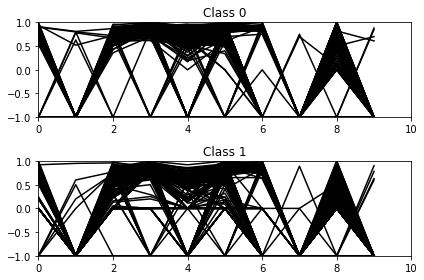

In [16]:
"""TSLEARN KNN Classifier"""

from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.neighbors import KNeighborsTimeSeriesClassifier, KNeighborsTimeSeries
from tslearn.piecewise import SymbolicAggregateApproximation
from tslearn.svm import TimeSeriesSVC
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_validate

print "Resampling: "
print Counter(label_model).items() #Antes del Sampling
#SMOTE
#X_first_resampled, y_first_resampled = SMOTE(random_state=42).fit_sample(series_model, label_model)
#RANDOM OVERSAMPLE
#X_first_resampled, y_first_resampled = RandomOverSampler(random_state=0).fit_sample(series_model, label_model)
#RANDOM UNDERSAMPLING
X_first_resampled, y_first_resampled = RandomUnderSampler(random_state=42).fit_sample(series_model, label_model)
print Counter(y_first_resampled).items() #Despues del Sampling


Number_of_Samples = 200 # Tamano fijo del dataset
X_resampled,y_resampled=balanced_sample_maker(X_first_resampled,y_first_resampled,Number_of_Samples)


ts_data_scaled = to_time_series_dataset(X_resampled)
#scaler = TimeSeriesScalerMinMax(min=0., max=1.)  # Rescale time series
#ts_data_scaled = scaler.fit_transform(ts_data)

print "Despues de Time Series FC"
print ts_data_scaled.shape

    
print(datetime.datetime.now())
# Nearest neighbor classification
scoring = {'accuracy': 'accuracy',
           'precision': 'precision',
           'recall': 'recall',
           'f1': 'f1'}

#KNN Classifier
#knn_clf = KNeighborsTimeSeriesClassifier(n_neighbors=1, metric="dtw")
#scores = cross_validate(knn_clf, ts_data_scaled, y_resampled, scoring=scoring, cv=5)
    
    
#SVM Classifier: 
#svm_clf = TimeSeriesSVC(sz=ts_data_scaled.shape[1], d=ts_data_scaled.shape[2], kernel="gak", gamma=0.1)
#scores = cross_validate(svm_clf, ts_data_scaled, y_resampled, scoring=scoring, cv=5)


print(datetime.datetime.now())


import matplotlib.pyplot as plt


plt.figure()
for yi in range(2):
    plt.subplot(2, 1, 1 + yi)
    for xx in X_first_resampled[y_first_resampled == yi]:
        plt.plot(xx.ravel(), "k-")
    plt.xlim(0, X_first_resampled.shape[1])
    plt.ylim(-1, 1)
    plt.title("Class %d" % (yi))

plt.tight_layout()
plt.show()


In [ ]:
"""SCORES"""
print(scores.keys())
print "Accuracy Score:" 
print np.average(scores['test_accuracy'])
print "Recall Score:"
print np.average(scores['test_recall'])
print "Precision Score:" 
print np.average(scores['test_precision'])
print "F1 Score:" 
print np.average(scores['test_f1'])
